<a href="https://colab.research.google.com/github/jayun1218/ktcloud_genai/blob/main/204_LLM_%E1%84%8B%E1%85%B5%E1%86%B7%E1%84%87%E1%85%A6%E1%84%83%E1%85%B5%E1%86%BC_%E1%84%86%E1%85%B5%E1%84%89%E1%85%A7%E1%86%AB%E1%84%87%E1%85%A9%E1%84%8E%E1%85%AE%E1%86%BC_%E1%84%8B%E1%85%AA%E1%86%AB%E1%84%89%E1%85%A5%E1%86%BC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **텍스트 임베딩 모델 만들기**



---


- 💡 **NOTE**
    - 이 노트북의 코드를 실행하려면 GPU를 사용하는 것이 좋습니다. 구글 코랩에서는 **런타임 > 런타임 유형 변경 > 하드웨어 가속기 > T4 GPU**를 선택하세요.


---



In [ ]:
# 깃허브에서 위젯 상태 오류를 피하기 위해 진행 표시줄을 나타내지 않도록 설정합니다.
import os
import tqdm
from transformers.utils import logging

# tqdm 비활성화
os.environ["DISABLE_TQDM"] = "1"

logging.disable_progress_bar()

In [ ]:
%%capture
# datasets를 MTEB 호환 버전 설치
!pip install 'datasets>=2.19.0,<3.0.0'

# pydantic을 MTEB 호환 버전 설치
!pip install 'pydantic>=2.0,<2.6'

# MTEB 최신 버전 설치
!pip install 'mteb>=1.39.0'

In [ ]:
# 0) 버전 확인(로그 용)
import sys, torch, datasets, sentence_transformers, mteb, transformers, numpy
print("Python:", sys.version)
print("torch:", torch.__version__, "| cuda:", torch.cuda.is_available())
print("transformers:", transformers.__version__)
print("sentence-transformers:", sentence_transformers.__version__)
print("datasets:", datasets.__version__)
print("mteb:", mteb.__version__)

Python: 3.12.12 (main, Oct 10 2025, 08:52:57) [GCC 11.4.0]
torch: 2.8.0+cu126 | cuda: True
transformers: 4.57.0
sentence-transformers: 5.1.1
datasets: 2.21.0
mteb: 1.39.7


## **임베딩과 대조학습**

- **임베딩(Embedding)**
    - (텍스트) 입력을 유용한 **벡터로 변환하는 과정** 또는 그 결과
    - 임베딩 과정은 **LLM(임베딩 모델)에 의해 수행**됨
- **임베딩 모델의 목적**
    - 텍스트 데이터를 가능한 정확하게 임베딩으로 표현하는 것
    - 정확한 표현이란? : **의미론적 특징(semantic nature)을 잘 포착하는 것**
    - 의미 포착 : **임베딩의 근접성**과 **유사성**으로 확인

### **예제: "우리 중에 스파이가 있어!"** - 이상한 단어 찾기 게임
단어 리스트에서 홀로 동떨어진 의미의 단어를 벡터 공간에서의 거리를 이용해 찾는 게임

In [ ]:
import numpy as np
from sentence_transformers import SentenceTransformer

# 모델 로드
model = SentenceTransformer('intfloat/multilingual-e5-base')

# 단어 리스트 (스파이가 하나 숨어있음)
words = ["컴퓨터", "노트북", "키보드", "모니터", "바나나"]

# 각 단어 임베딩
embeddings = model.encode(words)


# 각 단어 벡터 간의 평균 거리 계산
# (자신을 제외한 다른 모든 단어와의 평균 거리가 가장 먼 단어가 스파이!)
distances = []
for i in range(len(embeddings)):
    # i번째 단어와 다른 모든 단어 간의 유클리드 거리 합계
    dist_sum = sum([np.linalg.norm(embeddings[i] - embeddings[j]) for j in range(len(embeddings)) if i != j])
    distances.append(dist_sum)


# 평균 거리가 가장 먼 단어(스파이) 찾기
spy_index = np.argmax(distances)

print(f"단어 리스트: {words}")
print(f"스파이는 바로... '{words[spy_index]}'(이)야!")

# 결과 예측:
# 스파이는 바로... '바나나'(이)야!

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


단어 리스트: ['컴퓨터', '노트북', '키보드', '모니터', '바나나']
스파이는 바로... '바나나'(이)야!


- **대조학습(Contrastive learning)**
    - **비슷한 문서 쌍과 비슷하지 않은 문서 쌍으로 훈련하는 방법**
    - 임베딩 모델을 훈련하고 미세 튜닝하는 주요 방법
    - **레이블이 없는 데이터를 사용하여, 유사한 데이터는 가깝게, 다른 데이터는 멀게 만드는 표현(representation)을 학습하는 방법**
    - 이는 **데이터 증강을 통해 생성된 '긍정적인 쌍'(positive pair)과 '부정적인 쌍'(negative pair)의 거리를 조절하는 방식**으로 작동
    - 이 기법은 자기지도학습의 한 종류로, 레이블링 비용 없이도 효과적인 데이터 표현을 학습할 수 있다는 장점이 있음

- **대조 학습 목적**
    - 벡터 공간에서 비슷한 문서가 가까이 놓이고 비슷하지 않은 문서는 멀리 떨어지도록 임베딩 모델을 훈련하는 것-->(word2vec 방법과 유사)
- **대조 과정**
    - 문서의 의미를 정확하게 포착하기 위한 방법
    - 문서를 다르거나 비슷하게 만드는 요소를 모델이 학습하도록 여타 문서와 대조 시킨다.
        - **문서 간의 유사성/비유사성을 학습**
        - 비슷한 샘플 쌍과 비슷하지 않은 샘플 쌍을 모델에게 제공
- **대조적 설명 예**:
    - 기자 질문: `왜 은행을 털었나요?`
    - 도둑 답: `돈이 거기 있으니까?`
    - 기자의 질문 의도는 `왜 범죄를 저질렀는지를 알기 위함`
    - 질문의도 : `왜 Q(법을 지키다)가 아니고 P(은행을 털다)인가요?`
    - `왜 P인가요?`라는 질문을 `왜 Q가 아니고 P인가요?`로 이해해도록 만드는 방법
    
- **임베딩 모델 프레임워크**(**sentence-transformers**)
    - 대조 학습을 적용한 대표적인 텍스트 임베딩 모델 프레임워크
    - sentence-transformers : https://github.com/UKPLab/sentence-transformers



---



## **임베딩 모델 만들기**

- **임베딩 모델을 만드는 방**법 :  **대조 학습**(Contrastive learning)

### **데이터 준비**

- (**대조 샘플 생성**)사용 데이터셋 :
    - **GLUE(General Language Understanding Evaluation)** : AI 언어 모델이 얼마나 '종합적으로' 인간의 언어를 잘 이해하는지를 평가하기 위해 만들어진 벤치마크 모음
    - https://gluebenchmark.com/ 에서
    - **MNLI(Multi-Genre Natual Language Inference)** 말뭉치 :수반, 모순, 중립으로 레이블이 부여된  문장 쌍
    - **50,000개 문장 사용** (-->훈련 데이터셋이 클수록 품질이 좋지만 테스트를 위해 샘플 데이터 정도만 사용)

- **load_dataset() 함수의 주요 인자 (path, name, split)**
    - path	: 데이터셋의 '경로' 또는 '대분류'
    - name	: 데이터셋의 '이름' 또는 '소분류'
    - split	: 데이터의 '부분 집합'

In [ ]:
# 1) 데이터 준비
from datasets import load_dataset

# GLUE에서 MNLI 데이터셋을 로드합니다.
# 0 = 수반, 1 = 중립, 2 = 모순
train_dataset = load_dataset("glue", "mnli", split="train").select(range(50_000))
train_dataset = train_dataset.remove_columns("idx")

Generating train split:   0%|          | 0/392702 [00:00<?, ? examples/s]

Generating validation_matched split:   0%|          | 0/9815 [00:00<?, ? examples/s]

Generating validation_mismatched split:   0%|          | 0/9832 [00:00<?, ? examples/s]

Generating test_matched split:   0%|          | 0/9796 [00:00<?, ? examples/s]

Generating test_mismatched split:   0%|          | 0/9847 [00:00<?, ? examples/s]

In [ ]:
# huggingface datasets 구조 확인
train_dataset
# train_dataset.features
# train_dataset.shape
# train_dataset.column_names
# train_dataset.to_pandas()

Dataset({
    features: ['premise', 'hypothesis', 'label'],
    num_rows: 50000
})

In [ ]:
train_dataset[2]
# 전제(premise)와 가설(hypothesis)이 서로 관련되고 의미가 거의 동일: 0=수반에 해당

{'premise': 'One of our number will carry out your instructions minutely.',
 'hypothesis': 'A member of my team will execute your orders with immense precision.',
 'label': 0}

In [ ]:
import pandas as pd

df = pd.DataFrame(
    {
        "sentence1": train_dataset["premise"],
        "sentence2": train_dataset["hypothesis"],
        "label": train_dataset["label"]
    }
)
df.head()

,sentence1,sentence2,label
0,Conceptually cream skimming has two basic dime...,Product and geography are what make cream skim...,1
1,you know during the season and i guess at at y...,You lose the things to the following level if ...,0
2,One of our number will carry out your instruct...,A member of my team will execute your orders w...,0
3,How do you know? All this is their information...,This information belongs to them.,0
4,yeah i tell you what though if you go price so...,The tennis shoes have a range of prices.,1


In [ ]:
df['label'].unique()

array([1, 0, 2])

In [ ]:
# df['label']별 빈도 수
df['label'].value_counts()

,count
label,
2,17884
0,16875
1,15241


### **모델 선정**

In [ ]:
# 2) 모델 로드
from sentence_transformers import SentenceTransformer

embedding_model = SentenceTransformer("bert-base-uncased")

### **손실 함수 정의**
- 손실 함수(**Loss Function**):
    - 모델의 예측이 실제 정답과 얼마나 다른지를 나타내는 오답 점수로, 모델은 이 점수를 최소화하는 방향으로 학습함
- **다양한 손실함수**(for sentence-transformers) :
    - https://www.sbert.net/docs/package_reference/sentence_transformer/losses.html
- **SoftmaxLoss** :  
    - https://www.sbert.net/docs/package_reference/sentence_transformer/losses.html#softmaxloss
    - **핵심 아이디어**:
        - **"분류(Classification) 문제로 바꿔서 풀기"**
    - 이 방식은 두 문장을 입력받아 둘의 관계가 '유사한 관계(entailment)'인지, '상반된 관계(contradiction)'인지 분류하는 문제를 푼다.모델이 이 분류 문제를 잘 풀게 되면, 그 과정에서 문장의 의미를 잘 이해하게 되고 자연스럽게 좋은 임베딩이 만들어진다고 봄
    
    - **학습 과정** :
        1. (A, P) 쌍을 모델에 넣어주고 "이 둘은 유사한 관계야 (정답: 1)" 라고 알려줍니다.
        2. (A, N) 쌍을 모델에 넣어주고 "이 둘은 상반된 관계야 (정답: 0)" 라고 알려줍니다.
        3. 모델은 이 '정답 맞히기' 퀴즈를 계속 풀면서 문장의 미묘한 의미 차이를 학습합니다.
        - 요약: 두 문장의 관계를 맞히는 '분류' 작업을 통해 문장 임베딩 능력을 간접적으로 학습시킵니다.


In [ ]:
# 3) 손실 함수
from sentence_transformers import losses

# 소프트맥스 손실을 위해 명시적으로 레이블의 개수를 지정해야 합니다.
train_loss = losses.SoftmaxLoss(
    model=embedding_model,
    sentence_embedding_dimension=embedding_model.get_sentence_embedding_dimension(),
    num_labels=3    # 레이블 개수
)


### **평가자 정의**

- **Evaluator 객체**:
    - 훈련 과정에서 모델을 평가하고 디스크에 저장할 최상의 모델을 결정하기 위해 Evaluator 객체 정의
- **STS-B**(Semantic Textual Similarity Benchmark STS-B):
    - 모델 성능 평가 벤치마크, **문장 유사도 측정기**
    - 0~5사이의 실수로 유사도 점수 매겨 레이블을 부여한 문장 쌍으로 구성(5에 가까울 수록 문장 쌍이 비슷함을 의미)

In [ ]:
# 4) 평가자: STS-B (코사인 등 여러 유사도)
from sentence_transformers.evaluation import EmbeddingSimilarityEvaluator

val_sts = load_dataset('glue', 'stsb', split='validation')

evaluator = EmbeddingSimilarityEvaluator(
    sentences1=val_sts["sentence1"],
    sentences2=val_sts["sentence2"],
    scores=[score/5 for score in val_sts["label"]],   # 0~1 사이 값으로 조정
    main_similarity="cosine",
    similarity_fn_names=["cosine", "euclidean", "manhattan", "dot"]
)

Generating train split:   0%|          | 0/5749 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1500 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1379 [00:00<?, ? examples/s]

###**훈련**

- **훈련 매개변수 정의**
    - 주요 파라미터
        - **num_train_epochs** :  훈련 반복 횟수
        - **per_device_train_batch_size**  : 훈련 과정 중 장치에서 동시에 처리할 샘플 개수(높은 값이 빠른 훈련 속도를 의미)
        - **per_device_eval_batch_size** : 평가 과정 중 장치에서 동시에 처리할 샘플 개수(높은 값이 빠른 훈련 속도를 의미)
        - **warmup_steps** : 학습률이 0부터 훈련 매개변수로 지정한 초기 학습률까지 선형적으로 증가하는 단계의 수(default 100)
        - **fp16** : 16비트 부동소수점 사용 계산(혼합 정밀도 훈련 수행), 메모리 사용량 줄이고 훈련 속도 높일 수 있음 (default fp32)

In [ ]:
# 5) 학습 매개변수
from sentence_transformers.training_args import SentenceTransformerTrainingArguments

# 훈련 매개변수를 정의합니다.
args = SentenceTransformerTrainingArguments(
    output_dir="base_embedding_model",   # 임베딩 모델이 저장될 폴더명
    num_train_epochs=1,                  # 훈련 반복 횟수
    per_device_train_batch_size=32,      # 훈련 과정 중 장치에서 동시에 처리할 샘플 개수
    per_device_eval_batch_size=32,
    warmup_steps=100,
    fp16=True,      # torch.cuda.is_available(),   # GPU가 없으면 False가 자동 적용
    eval_steps=100,
    logging_steps=100,
    report_to=[]
)

- **임베딩 모델 훈련**
(T4에서 5~8분 정도 걸림)

In [ ]:
# 6) 트레이너 생성 & 학습
from sentence_transformers.trainer import SentenceTransformerTrainer

# 임베딩 모델을 훈련합니다.
trainer = SentenceTransformerTrainer(
    model=embedding_model,
    args=args,
    train_dataset=train_dataset,
    loss=train_loss,
    evaluator=evaluator
)
trainer.train()

# Step 계산 과정:
# - 전체 학습 데이터셋 (교과서 전체): 50,000개의 문장
# - 배치 크기 (Batch Size): 32 (한 번에 공부할 문장 수, 즉 '한 페이지' 분량)
# - 1 스텝 (Step): '한 페이지'(32개 문장)를 읽고 내용을 정리(가중치 업데이트)하는 행위
# - 1 에폭 (Epoch): 교과서 전체를 처음부터 끝까지 한 번 다 읽는 것
# - 1 에폭(Epoch)당 총 스텝 수: (전체 데이터 수) / (배치 크기) = 50,000 / 32 = 1562.5 --> 1563번 step

Computing widget examples:   0%|          | 0/1 [00:00<?, ?example/s]

dataset = dataset.select_columns(['hypothesis', 'entailment', 'contradiction'])


Step,Training Loss
100,1.078500
200,0.954000
300,0.899400
400,0.849700
500,0.828900
600,0.837600
700,0.815900
800,0.788900
900,0.775200
1000,0.774200


TrainOutput(global_step=1563, training_loss=0.8158265185218855, metrics={'train_runtime': 351.187, 'train_samples_per_second': 142.374, 'train_steps_per_second': 4.451, 'total_flos': 0.0, 'train_loss': 0.8158265185218855, 'epoch': 1.0})

- **모델 평가 결과**

In [ ]:
# 훈련된 모델을 평가합니다.
evaluator(embedding_model)

{'pearson_cosine': 0.5634063943977196,
 'spearman_cosine': 0.6323391926117837,
 'pearson_euclidean': 0.6103065677512692,
 'spearman_euclidean': 0.635644664643815,
 'pearson_manhattan': 0.6214313659589459,
 'spearman_manhattan': 0.6402859098396704,
 'pearson_dot': 0.5246058799405557,
 'spearman_dot': 0.5550486410521086,
 'pearson_max': 0.6214313659589459,
 'spearman_max': 0.6402859098396704}

### **MTEB(심층평가)**
- MTEB(**Massive Text Embedding Benchmark**)
    - **임베딩 모델(embedding model)의 품질을 객관적으로 평가하기 위한 벤치마크**(허깅페이스 연구팀)
    - https://huggingface.co/spaces/mteb/leaderboard
    - 203_LLM_텍스트분류.ipynb 참고
- **심층평가를 위한 Task** : **Banking77Classification**
    - 온라인 뱅킹 분야에서 사용자의 **의도(intent)를 분류**하기 위해 만들어진 데이터셋이자 평가 태스크
    - 챗봇이나 AI 비서가 **사용자의 요청을 얼마나 잘 이해하는지 측정**하는 표준 벤치마크로 널리 사용됨
    - 사용 방법
        - task_names = ["Banking77Classification"]
        - **STSBenchmark** : 문장 임베딩 모델의 가장 핵심적인 성능을 확인하는 대표적인 벤치마크
        - **EmotionClassification** : 문장을 주어진 감정(예: 기쁨, 슬픔, 분노) 카테고리로 얼마나 정확하게 분류하는지 평가
        - **SciFact** : 임베딩이 실용적인 검색(Search) 시나리오에서 얼마나 효과적인지 측정
        - **ArxivClusteringP2P** : 유사한 주제의 문서들이 서로 가깝게 모이는지 확인
        - **Banking77Classification** : 사용자의 의도(intent)를 분류, 사용자의 요청을 얼마나 잘 이해하는지 측정

In [ ]:
# (교재 추천 코드이나 오류 발생으로 아래 코드로 대체함)
# 오류 원인: MTEB, pydantic 태스크 메타데이터 호환성 오류
# from mteb import MTEB

# # 평가 작업을 선택합니다.
# evaluation = MTEB(tasks=["Banking77Classification"])

# # 결과를 계산합니다.
# results = evaluation.run(embedding_model)
# results

In [ ]:
# MTEB, pydantic 태스크 메타데이터 호환성 일치시킴
import mteb
import pydantic
from sentence_transformers import SentenceTransformer

embedding_model = SentenceTransformer("bert-base-uncased")

# 1. 평가하려는 모든 태스크의 '이름'을 리스트로 정의합니다.
task_names = ["Banking77Classification"]


# 2. 패치가 완료된 태스크 '객체'들을 담을 빈 리스트를 생성합니다.
patched_tasks_to_run = []


print("MTEB 평가 전, 태스크 메타데이터 호환성 패치를 시작합니다...")
# 3. 리스트에 있는 모든 태스크 이름에 대해 반복 작업을 수행합니다.
for name in task_names:
    # 3-1. 이름으로 태스크 '객체'를 불러옵니다.
    task = mteb.get_task(name)

    # 3-2. pydantic 버전에 맞춰 메타데이터를 딕셔너리로 변환합니다.
    if pydantic.VERSION.startswith("1."):
        meta_dict = task.metadata.to_dict()
    else:
        meta_dict = task.metadata.model_dump()

    # 3-3. 'languages' 키가 있는지 방어적으로 확인하고 처리합니다.
    if 'languages' not in meta_dict or not meta_dict['languages']:
        # 키가 없거나 리스트가 비어있으면, 새로 추가/설정합니다.
        print(f"  - '{name}' 태스크에 'languages' 키가 없어 ['en-en']으로 설정합니다.")
        meta_dict['languages'] = ['en-en']
    else:
        # 키가 있으면, 형식만 수정합니다.
        original_langs = meta_dict['languages']
        patched_langs = []
        for lang in original_langs:
            if '-' not in lang:
                patched_langs.append(f"{lang}-{lang}")
            else:
                patched_langs.append(lang)

        if original_langs != patched_langs:
            print(f"  - '{name}' 태스크 패치: {original_langs} -> {patched_langs}")
            meta_dict['languages'] = patched_langs

    # 3-4. 수정된 딕셔너리로 메타데이터 객체를 새로 만들어 교체합니다.
    task.metadata = task.metadata.__class__(**meta_dict)

    # 3-5. 패치가 완료된 태스크 객체를 최종 리스트에 '반드시' 추가합니다.
    patched_tasks_to_run.append(task)

# 4. '패치 완료된 객체 리스트'를 MTEB에 전달하여 평가 객체를 생성합니다.
#    이제 리스트가 비어있지 않으므로 IndexError가 발생하지 않습니다.
print("\n모든 태스크 패치 완료. MTEB 평가를 시작합니다.")
evaluation = mteb.MTEB(tasks=patched_tasks_to_run)

# 5. 평가를 실행합니다.
results = evaluation.run(
    embedding_model,
    output_folder="results/bert-base-uncased-final",
    eval_splits=["test"]
)

# 6. 결과 확인
print(results)

MTEB 평가 전, 태스크 메타데이터 호환성 패치를 시작합니다...
  - 'Banking77Classification' 태스크에 'languages' 키가 없어 ['en-en']으로 설정합니다.

모든 태스크 패치 완료. MTEB 평가를 시작합니다.


───────────────────────────────────────────────── Selected tasks  ─────────────────────────────────────────────────

Classification

- Banking77Classification, s2s

[TaskResult(task_name=Banking77Classification, scores=...)]


In [ ]:
# result 상세 정보 출력
import json
import os

file_path = "/content/results/bert-base-uncased-final/google-bert__bert-base-uncased/86b5e0934494bd15c9632b12f734a8a67f723594/Banking77Classification.json"
# Check if the file exists
if os.path.exists(file_path):
    with open(file_path, 'r') as f:
        data = json.load(f)
        print(json.dumps(data, indent=4)) # Pretty print the JSON data
else:
    print(f"파일을 찾을 수 없습니다: {file_path}")

{
    "dataset_revision": "0fd18e25b25c072e09e0d92ab615fda904d66300",
    "task_name": "Banking77Classification",
    "mteb_version": "1.39.7",
    "scores": {
        "test": [
            {
                "accuracy": 0.634643,
                "f1": 0.632842,
                "f1_weighted": 0.632842,
                "scores_per_experiment": [
                    {
                        "accuracy": 0.623701,
                        "f1": 0.619715,
                        "f1_weighted": 0.619715
                    },
                    {
                        "accuracy": 0.621753,
                        "f1": 0.621728,
                        "f1_weighted": 0.621728
                    },
                    {
                        "accuracy": 0.643182,
                        "f1": 0.640787,
                        "f1_weighted": 0.640787
                    },
                    {
                        "accuracy": 0.643506,
                        "f1": 0.643865,
         

- ⚠️ **VRAM 비우기**
    - 다음 코드를 사용해 VRAM(GPU RAM)을 비우세요. 만약 비워지지 않으면 노트북을 재시작해야 합니다. 코랩을 사용하는 경우 오른쪽의 리소스 탭에서 VRAM이 줄어 들었는지 확인할 수 있습니다. 또는 `!nvidia-smi` 명령을 실행하여 현재 사용량을 확인할 수 있습니다.

In [ ]:
import gc
import torch

gc.collect()
torch.cuda.empty_cache()

- ⚠️ **nvidia-smi** : (NVIDIA System Management Interface)
    - 시스템에 설치된 NVIDIA GPU의 상태를 모니터링하고 관리하기 위한 필수적인 커맨드 라인 유틸리티


In [ ]:
!nvidia-smi

Tue Oct 14 23:54:18 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   57C    P0             31W /   70W |    3038MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

### **손실 함수 변경**

- **다양한 손실함수**(for sentence-transformers) :  
    - https://www.sbert.net/docs/package_reference/sentence_transformer/losses.html
- 대표적인 손실 함수
    - **코사인 유사도 손실**
    - **MNR 손실** (Multiple negatives ranking)

#### **코사인 유사도 손실** (**CosineSimilarityLoss**)
- http://sbert.net/docs/package_reference/sentence_transformer/losses.html#cosinesimilarityloss
- **핵심 아이디어**:
    - **"유사도 점수 자체를 직접 학습하기"**
- 이 방식은 두 문장 벡터 간의 코사인 유사도(Cosine Similarity)가 우리가 정해준 목표 점수(e.g., 비슷하면 1, 다르면 0)와 가까워지도록 직접적으로 학습함
- **텍스트의 의미론적 유사도 작업에 사용**
- [0, 1] **사이의 유사도를 나타내는 레이블과 문장의 쌍으로 구성된 데이터에서 가장 잘 동작**

- **학습 과정**  :   
    1. (A, P) 쌍의 벡터를 계산하고, 두 벡터 간 코사인 유사도 점수가 1에 가까워지도록 모델을 업데이트합니다. (가까이 당기기)
    2. (A, N) 쌍의 벡터를 계산하고, 두 벡터 간 코사인 유사도 점수가 0 또는 -1에 가까워지도록 모델을 업데이트합니다. (멀리 밀어내기)
    - 요약: 벡터 공간상에서 비슷한 문장은 가깝게, 다른 문장은 멀어지도록 '거리'를 직접 조절합니다.


In [ ]:
# 1) 데이터 로드
from datasets import Dataset, load_dataset

# GLUE로부터 MNLI 데이터셋을 로드합니다.
# 0 = 수반, 1 = 중립, 2 = 모순
train_dataset = load_dataset("glue", "mnli", split="train").select(range(50_000))
train_dataset = train_dataset.remove_columns("idx")

# (중립/모순)=0, (수반)=1
mapping = {0: 1, 1: 0, 2: 0}
train_dataset = Dataset.from_dict({
    "sentence1": train_dataset["premise"],      # 전제
    "sentence2": train_dataset["hypothesis"],   # 가설
    "label": [float(mapping[label]) for label in train_dataset["label"]]
})
train_dataset[0]

{'sentence1': 'Conceptually cream skimming has two basic dimensions - product and geography.',
 'sentence2': 'Product and geography are what make cream skimming work. ',
 'label': 0.0}

In [ ]:
# 2) 평가자 정의
from sentence_transformers.evaluation import EmbeddingSimilarityEvaluator

# STSB를 위한 임베딩 유사도 평가자를 만듭니다.
val_sts = load_dataset('glue', 'stsb', split='validation')
evaluator = EmbeddingSimilarityEvaluator(
    sentences1=val_sts["sentence1"],
    sentences2=val_sts["sentence2"],
    scores=[score/5 for score in val_sts["label"]],
    main_similarity="cosine",
    similarity_fn_names=["cosine", "euclidean", "manhattan", "dot"]
)

In [ ]:
# 3) 모델 훈련 : 모델 정의 + 손실 함수 + 훈련 매개변수 + 모델 훈련
from sentence_transformers import losses, SentenceTransformer
from sentence_transformers.trainer import SentenceTransformerTrainer
from sentence_transformers.training_args import SentenceTransformerTrainingArguments

# 모델
embedding_model = SentenceTransformer('bert-base-uncased')

# 손실 함수
train_loss = losses.CosineSimilarityLoss(model=embedding_model)

# 훈련 매개변수
args = SentenceTransformerTrainingArguments(
    output_dir="cosineloss_embedding_model",
    num_train_epochs=1,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    warmup_steps=100,
    fp16=True,
    eval_steps=100,
    logging_steps=100,
    report_to=[]
)

# 모델 훈련
trainer = SentenceTransformerTrainer(
    model=embedding_model,
    args=args,
    train_dataset=train_dataset,
    loss=train_loss,
    evaluator=evaluator
)
trainer.train()

Computing widget examples:   0%|          | 0/1 [00:00<?, ?example/s]

Step,Training Loss
100,0.229600
200,0.171600
300,0.172300
400,0.158200
500,0.152900
600,0.157500
700,0.149100
800,0.157400
900,0.150300
1000,0.146500


TrainOutput(global_step=1563, training_loss=0.15720191035450687, metrics={'train_runtime': 474.4123, 'train_samples_per_second': 105.394, 'train_steps_per_second': 3.295, 'total_flos': 0.0, 'train_loss': 0.15720191035450687, 'epoch': 1.0})

In [ ]:
# 훈련된 모델을 평가합니다.
evaluator(embedding_model)

# CosineSimilarityLoss 손실함수 사용 결과:
# - 앞에서 사용한 SoftmaxLoss 결과('pearson_cosine': 0.533716951543377)
# - 보다 모델의 유사도가 향상됨 ('pearson_cosine': 0.7142764856270979)

{'pearson_cosine': 0.7258826905753328,
 'spearman_cosine': 0.7280507889124882,
 'pearson_euclidean': 0.7306384865540034,
 'spearman_euclidean': 0.7292284302945861,
 'pearson_manhattan': 0.7310924300678772,
 'spearman_manhattan': 0.7298255808216119,
 'pearson_dot': 0.669722165749105,
 'spearman_dot': 0.6743402073622569,
 'pearson_max': 0.7310924300678772,
 'spearman_max': 0.7298255808216119}

⚠️ **VRAM 비우기**

In [ ]:
import gc
import torch

gc.collect()
torch.cuda.empty_cache()

#### **MNR 손실** (**Multiple Negatives Ranking Loss**)
- https://www.sbert.net/docs/package_reference/sentence_transformer/losses.html#multiplenegativesrankingloss

- **핵심 아이디어**:
    - **"배치(Batch) 안에서 진짜 짝(Positive) 골라내기"**
- 가장 효율적인 방식 중 하나
- 한 번에 여러 개의 (Anchor, Positive) 쌍을 처리(배치 학습)하면서, 자신의 짝(Positive)을 수많은 방해물(다른 쌍의 Positive들) 속에서 가장 높은 순위로 찾아내는 '랭킹' 문제를 푼다.
-  기준이 되는 문장이 짝이 되는 **'긍정 문장'과는 가까워지도록**, 관련 없는 **여러 '부정 문장'들**과는 멀어지도록 학습시키는 손실 함수
    - 질문/답변 같이 관련된 텍스트 쌍의 거리는 최소화(의미가 비슷한 긍정 쌍은 서로 **끌어당기고**(pull) )
    - 질문과 관련없는 답변은 거리가 최대화(의미가 다른 여러 부정 쌍과는 **밀어내도록**(push) )하여 임베딩 공간을 효과적으로 학습
- infoNCE or NTXentLoss라고도 불림

- **학습 과정** :
    1. 미니 배치에 (A1, P1), (A2, P2), ..., (An, Pn)과 같이 여러 쌍을 넣습니다.
    2. A1을 기준으로, P1과의 유사도 점수가 나머지 모든 Positive(P2부터 Pn까지)와의 유사도 점수보다 월등히 높게 나오도록 모델을 학습시킵니다. 즉, A1에게 P1이 정답이고 나머지는 모두 오답(Negative)이라고 알려주는 것과 같습니다.
    - 요약: "보기 여러 개 중에 정답 고르기" 시험을 치르게 하여, 모델이 훨씬 더 정교하게 문장 쌍을 구분하도록 만듭니다.

In [ ]:
# 1) 데이터 로드
import random
from tqdm import tqdm
from datasets import Dataset, load_dataset

# GLUE로부터 MNLI 데이터셋을 로드합니다.
# 0 = 수반, 1 = 중립, 2 = 모순
mnli = load_dataset("glue", "mnli", split="train").select(range(50_000))
mnli = mnli.remove_columns("idx")

# MNLI의 레이블 중 0(수반 관계:전제와 가설이 서로 의미상 연관된 샘플)만
# '긍정 쌍(positive pair)'으로 지정
mnli = mnli.filter(lambda x: True if x['label'] == 0 else False)

# 데이터를 준비합니다.
# 삼중항(anchor:다른 문장과 비교하기 위해 사용)
train_dataset = {"anchor": [], "positive": [], "negative": []}

soft_negatives = mnli["hypothesis"]
random.shuffle(soft_negatives)
for row, soft_negative in tqdm(zip(mnli, soft_negatives)):
    train_dataset["anchor"].append(row["premise"])
    train_dataset["positive"].append(row["hypothesis"])
    train_dataset["negative"].append(soft_negative)

train_dataset = Dataset.from_dict(train_dataset)
len(train_dataset)

16875it [00:01, 15964.77it/s]


16875

In [ ]:
# zip 객체의 길이를 확인하는 방법 (zip 객체를 리스트로 변환하여 길이를 계산)
print(f"zip 객체의 개수: {len(list(zip(mnli, soft_negatives)))}")


zip 객체의 개수: 16875


In [ ]:
# 2) 평가자 정의
from sentence_transformers.evaluation import EmbeddingSimilarityEvaluator

# STS-B를 위해 임베딩 유사도 평가자를 만듭니다.
val_sts = load_dataset('glue', 'stsb', split='validation')
evaluator = EmbeddingSimilarityEvaluator(
    sentences1=val_sts["sentence1"],
    sentences2=val_sts["sentence2"],
    scores=[score/5 for score in val_sts["label"]],
    main_similarity="cosine",
    similarity_fn_names=["cosine", "euclidean", "manhattan", "dot"]
)

In [ ]:
# 3) 모델 훈련 : 모델 정의 + 손실 함수 + 훈련 매개변수 + 모델 훈련
from sentence_transformers import losses, SentenceTransformer
from sentence_transformers.trainer import SentenceTransformerTrainer
from sentence_transformers.training_args import SentenceTransformerTrainingArguments

# 모델
embedding_model = SentenceTransformer('bert-base-uncased')

# 손실 함수
train_loss = losses.MultipleNegativesRankingLoss(model=embedding_model)

# 훈련 매개변수
args = SentenceTransformerTrainingArguments(
    output_dir="mnrloss_embedding_model",
    num_train_epochs=1,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    warmup_steps=100,
    fp16=True,
    eval_steps=100,
    logging_steps=100,
    report_to=[]
)

# 모델 훈련
trainer = SentenceTransformerTrainer(
    model=embedding_model,
    args=args,
    train_dataset=train_dataset,
    loss=train_loss,
    evaluator=evaluator
)
trainer.train()

Computing widget examples:   0%|          | 0/1 [00:00<?, ?example/s]

Step,Training Loss
100,0.319500
200,0.100400
300,0.077000
400,0.064700
500,0.070800


TrainOutput(global_step=528, training_loss=0.1230570145628669, metrics={'train_runtime': 193.9333, 'train_samples_per_second': 87.014, 'train_steps_per_second': 2.723, 'total_flos': 0.0, 'train_loss': 0.1230570145628669, 'epoch': 1.0})

In [ ]:
# 훈련된 모델을 평가합니다.
evaluator(embedding_model)

# MultipleNegativesRankingLoss 손실함수 사용 결과 :
# - 앞에서 사용한 SoftmaxLoss 결과('pearson_cosine': 0.533716951543377)
# - 앞에서 사용한 CosineSimilarityLoss 결과 ('pearson_cosine': 0.7142764856270979)
# - 보다 모델의 유사도가 향상됨 ('pearson_cosine': 0.8017878954247927)

{'pearson_cosine': 0.8083596311684769,
 'spearman_cosine': 0.8115908821515868,
 'pearson_euclidean': 0.8235014426543896,
 'spearman_euclidean': 0.819436204291706,
 'pearson_manhattan': 0.8233078618510691,
 'spearman_manhattan': 0.8193384088505508,
 'pearson_dot': 0.725429381379252,
 'spearman_dot': 0.7170192990931337,
 'pearson_max': 0.8235014426543896,
 'spearman_max': 0.819436204291706}

⚠️ **VRAM 비우기**

In [ ]:
import gc
import torch

gc.collect()
torch.cuda.empty_cache()



---



## **[미션] 임베딩 만들기 코랩 파일 보충하기**
- 텍스트 셀의 내용은 풍부하게 보충
- 코드 따라해 보고, 코드를 수정해면서 실습해보는 것
- 20251014-미션-임베딩 모델 만들기-양습엽.ipynb

# ## **[미션] 임베딩 만들기 코랩 파일 보충하기**
*작성일: 2025-10-15*

아래 미션은 **텍스트 셀(개념·절차·팁)**을 풍부하게 보강하고, **코드 셀(실습)**은 그대로 따라한 뒤 **직접 수정**하며 탐구하도록 설계되어 있습니다.  
**인터넷 없이도 실행** 가능하도록 `scikit-learn` 기반 **TF‑IDF 임베딩**을 사용합니다. (Colab에서 GPU/인터넷 필요 없음)

---

### ✅ 이번 미션의 목표
1. 임베딩의 개념과 유형(통계적 vs. 신경망 기반)을 직관적으로 이해한다.  
2. 간단한 **텍스트 임베딩 → 유사도 계산 → 최근접 검색** 파이프라인을 직접 구현한다.  
3. 하이퍼파라미터(토큰화, n‑gram, 정규화 등)를 **직접 수정**하여 결과 변화(유사도, 최근접 이웃)를 체감한다.  
4. 작은 **평가 실험(positive/negative 쿼리, OOD 쿼리)**로 한계와 개선지점을 기록한다.

---

### 📦 실습 데이터 개요
- 주제: 간단한 **게임/쇼핑/일상 문장** 30개 내외
- 목적: 서로 의미가 비슷한 문장들을 **벡터 공간에서 가깝게** 모이게 만들기

---

### 🔎 실습 구조(파이프라인)
1. 텍스트 전처리 (소문자화, 불용어 제거 여부)  
2. 벡터화(임베딩) — **TF‑IDF**  
3. 유사도 계산 — **Cosine Similarity**  
4. 최근접 검색 — **k‑NN**  
5. 시각화 — **PCA 2D**(간단 확인)  
6. 실험 과제 — **하이퍼파라미터/데이터 수정** & **관찰 기록**

> 💡 *주의*: 실제 서비스에서는 `sentence-transformers`/`open-source LLM` 임베딩이 더 성능이 좋지만, 본 미션은 **의존성 없이 원리 체험**을 목표로 합니다.


---

## 1) 임베딩이란?
- **정의**: 텍스트(문장/문서)를 **숫자 벡터**로 바꾸는 함수. 벡터 공간에서 **의미적 유사도**를 거리/각도로 비교 가능.
- **유형**
  - **통계적 기반**: BOW, TF‑IDF, LSA 등 — 구현이 간단, 빠름.  
  - **신경망 기반**: Word2Vec, GloVe, FastText, Sentence‑BERT 등 — 의미 보존력↑, 문장 수준 표현에 강함.
- **활용**: 검색(Retrieval), 추천, 군집화, 중복 문서 제거, 이상치 탐지 등.

## 2) 왜 TF‑IDF로 시작할까?
- 인터넷/사전 설치 없이 **바로 실행** 가능.
- 직관적(단어 가중치)이며, **하이퍼파라미터 수정 효과**(n‑gram, stop words, sublinear_tf 등)를 관찰하기 좋음.

## 3) 유사도 계산과 최근접 검색
- **Cosine Similarity**: 벡터 방향 유사도를 [-1,1]로 측정.  
- **k‑Nearest Neighbors(k‑NN)**: 쿼리 벡터와 가장 가까운 k개 문서를 찾기.

## 4) 작은 평가법
- **Positive 쿼리**: 데이터에 존재/유사 주제의 문장 → 상위에 관련 문장 기대  
- **Negative/OOD 쿼리**: 없는 주제(예: 의료) → 유사도가 전반적으로 낮아야 정상  
- **오류 분석**: 틀린 매칭 사례를 기록하고, 파라미터/데이터 정제로 개선 포인트 찾기

---


In [ ]:
# === (A) 실습용 미니 코퍼스 만들기 ===
docs = [
    # 게임 관련
    "요즘 코랄아일랜드 게임에 빠져서 밤새 했다",
    "스타듀밸리 같은 농장 경영 게임을 좋아한다",
    "MMORPG에서 파티 플레이가 제일 재미있다",
    "레이드 보스 공략을 위해 공대 모집 중",
    "프레임 드랍 때문에 옵션을 낮췄다",
    "유니티로 개발한 인디 게임을 출시했다",
    "언리얼 엔진 블루프린트로 프로토타입 제작",
    "콘솔 패드로 하는 액션 게임의 타격감이 좋다",
    "로그라이크 던전에서 무기 밸런스를 조정했다",
    "코루틴을 활용해 스폰 타이밍을 분산했다",

    # 쇼핑/리뷰
    "가격 대비 성능이 좋은 무선 이어폰을 찾는 중",
    "배송이 너무 늦어서 별점 두 개를 줬다",
    "이 커피머신은 유지보수가 쉬워서 만족스럽다",
    "리뷰 사진과 실물이 조금 달랐다",
    "교환 응대가 친절해서 재구매 의사가 생겼다",

    # 일상
    "아침엔 꼭 산책을 하며 하루를 시작한다",
    "주말에 카페에서 코딩 공부를 했다",
    "비가 와서 실내 운동을 대신 했다",
    "새로 산 노트북이 생각보다 가볍다",
    "내일 발표 대본을 다시 정리해야 한다",

    # 개발/AI
    "파이썬으로 텍스트 전처리를 실습했다",
    "TF-IDF 임베딩으로 코사인 유사도를 계산했다",
    "문장 임베딩을 이용해 유사 문서 검색기를 만들었다",
    "하이퍼파라미터를 바꾸면 검색 결과가 달라졌다",
    "PCA로 벡터를 2차원에 시각화해 분포를 확인했다",

    # 기타
    "헬스장에서 스쿼트 중량을 기록했다",
    "여행 갈 때는 가벼운 백팩이 편하다",
    "고양이가 키보드 위에서 잠들었다",
    "친구와 보드게임을 하며 저녁을 보냈다",
    "새벽에 별을 보니 마음이 차분해졌다"
]
len(docs)


30

In [ ]:
# === (B) TF-IDF 임베딩 생성 ===
from sklearn.feature_extraction.text import TfidfVectorizer

# 기본 설정으로 시작해보고, 아래 TODO를 바꿔가며 관찰해보세요.
vectorizer = TfidfVectorizer(
    lowercase=True,        # 모두 소문자
    analyzer="word",       # 단어 단위 토큰화
    ngram_range=(1,2),     # <-- TODO: (1,1), (1,2), (2,2) 등으로 바꿔보세요
    min_df=1,              # 최소 등장 문서 빈도
    max_df=0.95,           # 너무 흔한 단어 배제 (0.8~1.0 사이 조정)
    sublinear_tf=True      # <-- TODO: True/False로 바꿔보며 영향 보기
)

X = vectorizer.fit_transform(docs)   # shape: (문서 개수, 특징 차원)
X.shape


(30, 286)

In [ ]:
# === (C) 코사인 유사도 및 최근접 검색 ===
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

def top_k_similar(query, k=5):
    # 쿼리를 같은 벡터라이저로 변환
    qv = vectorizer.transform([query])
    sims = cosine_similarity(qv, X)[0]  # 각 문서와의 유사도
    idx = np.argsort(-sims)[:k]
    return [(int(i), float(sims[i]), docs[i]) for i in idx]

# 테스트: 유사한 주제 쿼리
queries = [
    "농장 경영 게임 추천",
    "배송이 느리고 교환이 불편했다",
    "TF-IDF로 문장 유사도 실험",
    "헬스장에서 운동 기록하는 방법",
    "의료 영상 분할 네트워크"  # OOD(주제 밖) 쿼리
]

for q in queries:
    print(f"\n[Query] {q}")
    for i, s, d in top_k_similar(q, k=3):
        print(f"  -> score={s:.3f} | idx={i} | {d[:60]}")



[Query] 농장 경영 게임 추천
  -> score=0.527 | idx=1 | 스타듀밸리 같은 농장 경영 게임을 좋아한다
  -> score=0.000 | idx=0 | 요즘 코랄아일랜드 게임에 빠져서 밤새 했다
  -> score=0.000 | idx=2 | MMORPG에서 파티 플레이가 제일 재미있다

[Query] 배송이 느리고 교환이 불편했다
  -> score=0.302 | idx=11 | 배송이 너무 늦어서 별점 두 개를 줬다
  -> score=0.000 | idx=0 | 요즘 코랄아일랜드 게임에 빠져서 밤새 했다
  -> score=0.000 | idx=2 | MMORPG에서 파티 플레이가 제일 재미있다

[Query] TF-IDF로 문장 유사도 실험
  -> score=0.213 | idx=21 | TF-IDF 임베딩으로 코사인 유사도를 계산했다
  -> score=0.196 | idx=22 | 문장 임베딩을 이용해 유사 문서 검색기를 만들었다
  -> score=0.000 | idx=0 | 요즘 코랄아일랜드 게임에 빠져서 밤새 했다

[Query] 헬스장에서 운동 기록하는 방법
  -> score=0.378 | idx=25 | 헬스장에서 스쿼트 중량을 기록했다
  -> score=0.000 | idx=0 | 요즘 코랄아일랜드 게임에 빠져서 밤새 했다
  -> score=0.000 | idx=2 | MMORPG에서 파티 플레이가 제일 재미있다

[Query] 의료 영상 분할 네트워크
  -> score=0.000 | idx=0 | 요즘 코랄아일랜드 게임에 빠져서 밤새 했다
  -> score=0.000 | idx=1 | 스타듀밸리 같은 농장 경영 게임을 좋아한다
  -> score=0.000 | idx=2 | MMORPG에서 파티 플레이가 제일 재미있다


In [ ]:
# === (폰트 설정: 한글 깨짐 방지 - Colab용) ===
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc
import platform
import os

if platform.system() == 'Darwin':  # macOS
    rc('font', family='AppleGothic')
elif platform.system() == 'Windows':
    rc('font', family='Malgun Gothic')
else:  # Linux (예: Colab)
    # 🟢 폰트 설치 (최초 1회만 실행)
    !apt -qq -y install fonts-nanum > /dev/null
    # 폰트 캐시 갱신
    font_dir = '/usr/share/fonts/truetype/nanum'
    font_manager.fontManager.addfont(os.path.join(font_dir, 'NanumGothic.ttf'))
    plt.rc('font', family='NanumGothic')

plt.rcParams['axes.unicode_minus'] = False
print("✅ 한글 폰트 설정 완료")




✅ 한글 폰트 설정 완료


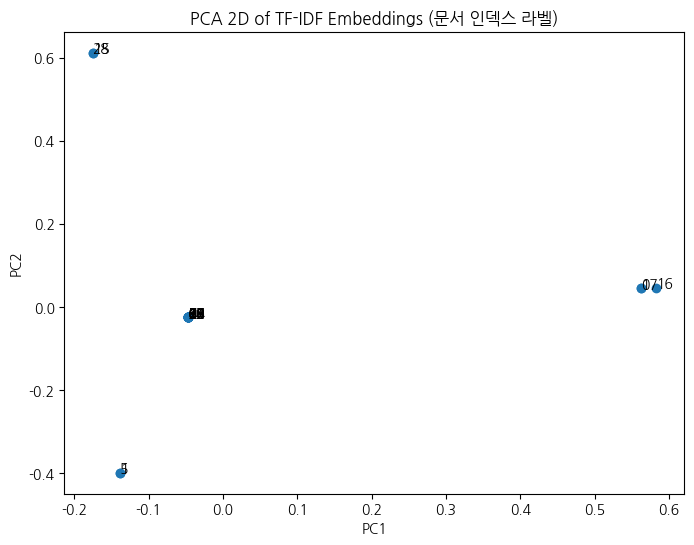

In [ ]:
# === (D) 2D 시각화 (PCA) ===
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# 밀집 행렬로 변환해서 PCA
X_dense = X.toarray()
pca = PCA(n_components=2, random_state=42)
XY = pca.fit_transform(X_dense)

plt.figure(figsize=(8,6))
plt.scatter(XY[:,0], XY[:,1])
for i, txt in enumerate(range(len(docs))):
    plt.annotate(txt, (XY[i,0], XY[i,1]))
plt.title("PCA 2D of TF-IDF Embeddings (문서 인덱스 라벨)")
plt.xlabel("PC1"); plt.ylabel("PC2")
plt.show()


---

## ✍️ 제출/정리 가이드 (노션/블로그용)
- **개념 요약**: 임베딩 정의, TF‑IDF 원리, 코사인 유사도 한 줄 요약
- **실험 로그**: (설정) → (쿼리) → (Top‑k 결과/점수) → (관찰/해석) 표로 정리
- **인사이트**: 어떤 설정이 잘 먹히는가? 한계는 무엇인가?
